In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import numpy as np

In [4]:
# load data
data = pd.read_csv("./data/BTC-USD-1d.csv")

# data preprocessing

data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=10)
data['EMAM'] = ta.ema(data['Close'], length=30)
data['EMAS'] = ta.ema(data['Close'], length=50)
data.ta.bbands(close='Close', length=10, std=2, append=True)
pd.set_option("display.max_columns", None)

data['Target'] = data['Adj Close'] - data['Open']
data['Target'] = data['Target'].shift(-1)
data['TargetNextClose'] = data['Adj Close'].shift(-1)

# TODO clean
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Date'], axis=1, inplace=True)
# data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
dataset = data.iloc[:, 0:len(data.columns)]

In [5]:
# data scaling 
min_vals = dataset.min()
max_vals = dataset.max()
dataset = (dataset - min_vals) / (max_vals - min_vals)

In [ ]:
dataset

In [6]:
# TODO feature engineering
backcandles = 10
X = []
for j in range(len(dataset.columns)):
    X.append([])
    for i in range(backcandles, len(dataset)):
        X[j].append(dataset.iloc[i - backcandles:i, j].values)

X = np.moveaxis(X, [0], [2])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(dataset.iloc[backcandles:, -1].values, dtype=torch.float32).reshape(-1, 1)

In [7]:
# split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [9]:
# parameters
input_size = X.shape[2]
hidden_size = 256
num_layers = 2
num_epochs = 50
batch_size = 15
learning_rate = 0.0005

In [10]:
model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [11]:
# train
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0011
Epoch [20/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0002
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0001


In [12]:
# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test)


In [13]:
dataset.head()

,index,Adj Close,Close,High,Low,Open,Volume,RSI,EMAF,EMAM,EMAS,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,Target,TargetNextClose
0,0.000000,0.002395,0.002395,0.001920,0.002404,0.002283,0.000038,0.371073,0.001806,0.002053,0.002361,0.002553,0.001955,0.001884,0.136006,0.529422,0.509212,0.002540
1,0.000376,0.002540,0.002540,0.002059,0.002521,0.002413,0.000035,0.430005,0.001835,0.002044,0.002346,0.002562,0.001950,0.001865,0.129802,0.700421,0.508053,0.002438
2,0.000753,0.002438,0.002438,0.002056,0.002572,0.002567,0.000029,0.396986,0.001839,0.002029,0.002326,0.002610,0.001926,0.001778,0.100642,0.640979,0.508775,0.002484
3,0.001129,0.002484,0.002484,0.001973,0.002577,0.002453,0.000006,0.415671,0.001851,0.002017,0.002309,0.002610,0.001941,0.001806,0.106840,0.674995,0.509753,0.002748
4,0.001505,0.002748,0.002748,0.002215,0.002609,0.002501,0.000050,0.511853,0.001911,0.002026,0.002305,0.002543,0.001969,0.001919,0.145652,0.868405,0.508864,0.002802


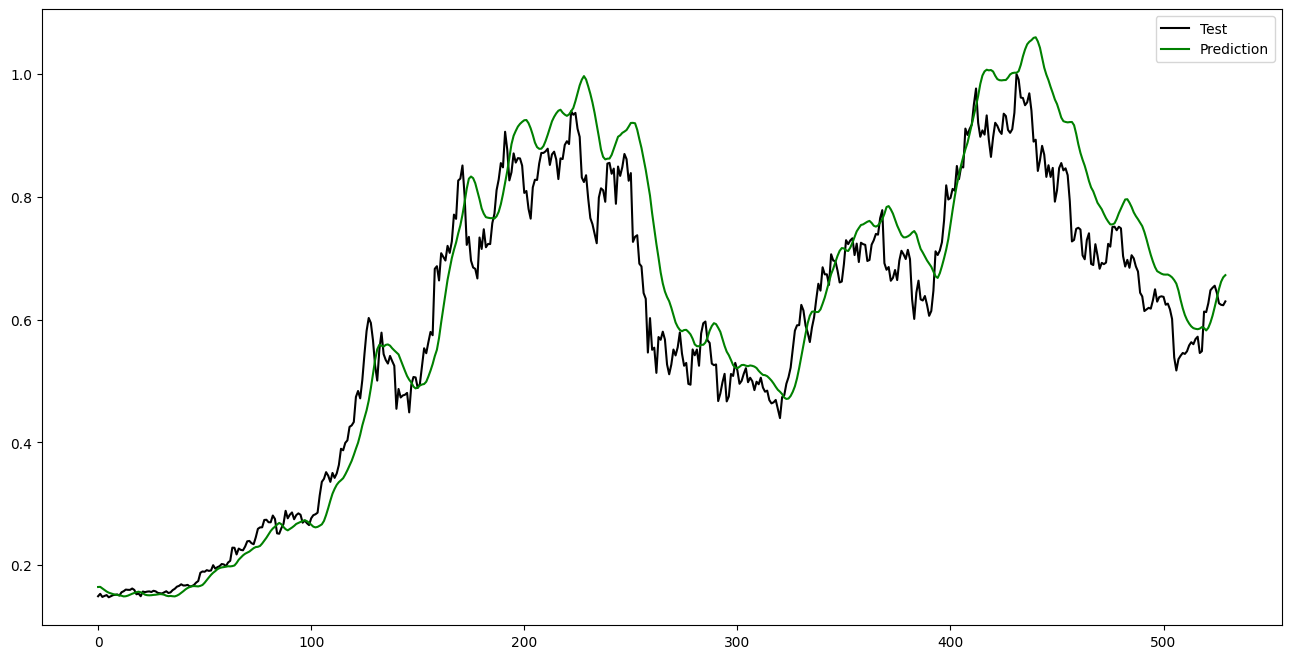

In [14]:
# plot
plt.figure(figsize=(16, 8))
plt.plot(y_test.numpy(), color='black', label='Test')
plt.plot(y_pred.numpy(), color='green', label='Prediction')
plt.legend()
plt.show()